<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

Iniciamos calcuando los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$.

Damos mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [34]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [35]:
def local_regression(X,W,Xo):
    # W     : Matriz diagonal de pesos
    # X     : Regresores
    # xo    : punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

In [36]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente `X` serán los datos de demanda del día anterior, y los datos independiente `Y` serán los datos de días con una mayor correlación con `X`. En esta sección, aplicaremos técnicas de regresión local con multiples regresores `X`. Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [37]:
df  = pd.read_csv('demanda.csv')
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
X   = pd.DataFrame(df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

## Muestreo **bootstrap** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple
En esta función se calcula un modelo de regresión lineal múltiple para una de las muestras `X_train` elegidas aleatoriamente un 50% de datos del total del conjunto `X`. Los datos de error (MAE) de todas las réplicas del muestreo aleatorio se guardan en la lista `bootstrap_ols`.

In [38]:
bootstrap_ols= []

for rep in range(1000):
    a = np.arange(0,X.shape[0])
    b = np.sort(np.random.choice(a, replace=False, size = int(len(a)*0.5)))
    #c = np.sort(np.setdiff1d(a, b)) El complemento del conjunto seleccionado
    X_train = np.delete(X, b, axis = 0)
    Y_train = np.delete(Y, b, axis = 0)
    
    olsmod = sm.OLS(Y_train, X_train)
    olsres = olsmod.fit()
    Y_pred = olsres.predict(X_train)  
    bootstrap_ols.append(mean_absolute_error(Y_train,Y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

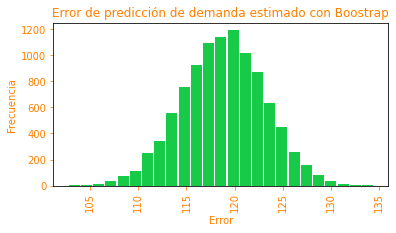

0    118.801492
dtype: float64
0    4.27236
dtype: float64


In [40]:
dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
bootstrap_mean = dfb.mean(numeric_only = True)
bootstrap_std = dfb.std(numeric_only = True)
dibuja_hist(dfb,colour='#17cb49',name='hist_t7_1.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Boostrap")
print(bootstrap_mean)
print(bootstrap_std)

## Muestreo **cross-validation** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple
En esta función se calcula un modelo de regresión lineal múltiple para cada una de las una de las muestras `X_test` extraidas del total del conjunto de entrenamiento `X_train`. Los datos de error del muestreo cross-validation se guardan en la lista cross_ols.

In [ ]:
bootstrap_ols= []

for rep in range(10000):
    a = np.arange(0,X.shape[0])
    b = np.sort(np.random.choice(a, replace=False, size = int(len(a)*0.5)))
    #c = np.sort(np.setdiff1d(a, b))
    X_train = np.delete(X, b, axis = 0)
    Y_train = np.delete(Y, b, axis = 0)
    
    olsmod = sm.OLS(Y_train, X_train)
    olsres = olsmod.fit()
    Y_pred = olsres.predict(X_train)}    
    bootstrap_ols.append(mean_absolute_error(Y_train,Y_pred))

In [ ]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [ ]:
mae_pred  = trunc(mean_absolute_error(Y,Y_pred),4)
mae_local_k0 = trunc(mean_absolute_error(Y,Y_local_list[0]),4)
mae_local_k1 = trunc(mean_absolute_error(Y,Y_local_list[1]),4)
mae_local_k2 = trunc(mean_absolute_error(Y,Y_local_list[2]),4)
mae_local_k3 = trunc(mean_absolute_error(Y,Y_local_list[3]),4)
mae_local_k4 = trunc(mean_absolute_error(Y,Y_local_list[4]),4)

In [ ]:
mse_pred  = trunc(mean_squared_error(Y,Y_pred),4)
mse_local_k0 = trunc(mean_squared_error(Y,Y_local_list[0]),4)
mse_local_k1 = trunc(mean_squared_error(Y,Y_local_list[1]),4)
mse_local_k2 = trunc(mean_squared_error(Y,Y_local_list[2]),4)
mse_local_k3 = trunc(mean_squared_error(Y,Y_local_list[3]),4)
mse_local_k4 = trunc(mean_squared_error(Y,Y_local_list[4]),4)

In [ ]:
mape_pred  = trunc(mean_absolute_percentage_error(Y,Y_pred),4)
mape_local_k0 = trunc(mean_absolute_percentage_error(Y,Y_local_list[0]),4)
mape_local_k1 = trunc(mean_absolute_percentage_error(Y,Y_local_list[1]),4)
mape_local_k2 = trunc(mean_absolute_percentage_error(Y,Y_local_list[2]),4)
mape_local_k3 = trunc(mean_absolute_percentage_error(Y,Y_local_list[3]),4)
mape_local_k4 = trunc(mean_absolute_percentage_error(Y,Y_local_list[4]),4)

print('| REGRESIÓN      | MAE            | MSD            | MAPE         |')
print('| :------------- | -------------: | -------------: |-------------:|')
print('| local, k=10 |',str(mae_local_k0),'   |',str(mse_local_k0),'   |   ',str(mape_local_k0),'|')
print('| local, k=25 |',str(mae_local_k1),'   |',str(mse_local_k1),'   |   ',str(mape_local_k1),'|')
print('| local, k=35 |',str(mae_local_k2),'   |',str(mse_local_k2),'   |   ',str(mape_local_k2),'|')
print('| local, k=50 |',str(mae_local_k3),'   |',str(mse_local_k3),'   |   ',str(mape_local_k3),'|')
print('| local, k=100|',str(mae_local_k4),'   |',str(mse_local_k4),'   |   ',str(mape_local_k4),'|')
print('|    lineal      |',str(mae_pred),'    |',str(mse_pred),'   |   ',str(mape_pred),'|')

Graficamos los resultados de predicción de la regresión local con k= [10,25,35,50] y regresión local para pronosticar los datos de prueba `Y`.

In [ ]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(Y) )
plt.scatter( AUX,Y,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( Y_local_list[0], '.-' , color = LETRASNARA , label = 'Y_local,k>=10'   ,alpha=1/2)
axes.plot  ( Y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
axes.plot  ( Y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
axes.plot  ( Y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
axes.plot  ( Y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( Y_pred         , '--' , color = 'red'      , label = 'Y_lineal'       ,alpha=1/2)
#axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

plt.axis([0,  600, 7650, 9800])
plt.axis([100,  200, 7650, 9500])
plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_3.png', transparent=True)
plt.show()